In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
### Importing the required libraries

import os

import pandas as pd
import numpy as np
import cv2

from tensorflow.keras.models import Model, load_model
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
### Importing and unzipping the data from Gdrive
!unzip '/content/drive/MyDrive/NJU2K.zip' -d '/content/NJU2K'

In [ ]:
### Creating the DataFrame with the paths of RGB,Depth and GT images

def return_images_df(path):
    # writing  the code that will create a dataframe with two columns ['RGB', 'Depth','GT']
    # the column 'RGB' will have path to RGB images
    # the column 'Depth' will have path to Depth images
    # The column 'GT' will have path to Ground Truth images
    RGB_images=[]
    Depth_images=[]
    GT_images=[]
    for i in os.listdir(path):
      if i=='GT-1985':
        for j in sorted(os.listdir(os.path.join(path,i))):
          GT_images.append(os.path.join(os.path.join(path,i),j))
    
      if i=='RGB_left':
        for j in sorted(os.listdir(os.path.join(path,i))):
          RGB_images.append(os.path.join(os.path.join(path,i),j))

      if i=='depth':
        for j in sorted(os.listdir(os.path.join(path,i))):
          Depth_images.append(os.path.join(os.path.join(path,i),j))
    
    dict={'RGB':RGB_images,'Depth':Depth_images,'GT':GT_images}
    
    data_df=pd.DataFrame(dict)

    return data_df

In [ ]:
## Creating the DataFrame
root_dir='/content/NJU2K/NJU2K'
data_df = return_images_df(root_dir)
print(data_df.shape)
data_df.head()

(1985, 3)


RGB  ...                                            GT
0  /content/NJU2K/NJU2K/RGB_left/000001_left.jpg  ...  /content/NJU2K/NJU2K/GT-1985/000001_left.png
1  /content/NJU2K/NJU2K/RGB_left/000002_left.jpg  ...  /content/NJU2K/NJU2K/GT-1985/000002_left.png
2  /content/NJU2K/NJU2K/RGB_left/000003_left.jpg  ...  /content/NJU2K/NJU2K/GT-1985/000003_left.png
3  /content/NJU2K/NJU2K/RGB_left/000004_left.jpg  ...  /content/NJU2K/NJU2K/GT-1985/000004_left.png
4  /content/NJU2K/NJU2K/RGB_left/000005_left.jpg  ...  /content/NJU2K/NJU2K/GT-1985/000005_left.png

[5 rows x 3 columns]

In [ ]:
### Splitting the Dataset into Train and test
X_train, X_test = train_test_split(data_df, test_size=0.20, random_state=42)

In [ ]:
def input_prep(images):

        RGB_image = cv2.imread(images[0][0], cv2.IMREAD_UNCHANGED)

        RGB_image =cv2.resize(RGB_image,(160,160),interpolation=cv2.INTER_AREA)   ## Loading the RGB image and resizing it to required size
        
        RGB_image=np.expand_dims(RGB_image/255,axis=0)


        Depth_image = cv2.imread(images[0][1]) 

        Depth_image =cv2.resize(Depth_image,(160,160),interpolation=cv2.INTER_AREA)  ## Loading the Depth image and resizing it to required size

        Depth_image=np.expand_dims(Depth_image/255,axis=0)


        GT_image = cv2.imread(images[0][2],0) 

        GT_image_init =cv2.resize(GT_image,(160,160),interpolation=cv2.INTER_AREA)    ## Loading the Ground Truth image and resizing it to required size

        GT_images=[np.where((GT_image_init == v),1,0).astype('float32') for v in [0,255]]   ## Creating two channels for two classes

        GT_image=np.stack(GT_images, axis=-1).astype('float') 

        return [RGB_image,Depth_image],GT_image


We trained total 4 models :

1.JL-DCF Network with basic parameters and VGG16 as backbone network

2.JL-DCF Network with basic parameters,additional conv layers and VGG16 as backbone network

3.JL-DCF Network with basic parameters and Resnet101 as backbone network

4.JL-DCF Network with basic parameters,additional conv layers and Resnet101 as backbone network

Among the 4 of them we have to choose the better model for this we are using the E-score.

In [ ]:
### Calculating the E_score  https://www.ijcai.org/proceedings/2018/0097.pdf

def E_score(actual_image,pred_image):

    w=actual_image.shape[1]
    h=actual_image.shape[2]
    
    pred_image=np.reshape(pred_image,(w,h))

    actual_image=np.reshape(actual_image,(w,h))

    bias_pred=pred_image-np.ones((w,h))*np.mean(pred_image)  ### Calculating the bias matrix of predicted image

    bias_gt=actual_image-np.ones((w,h))*np.mean(actual_image)   ### Calculating the bias matrix of ground truth image

    FM=(2*bias_pred*bias_gt)/((bias_gt*bias_gt)+(bias_pred*bias_pred))  ### Calculating the alighnment matrix of ground truth image

    f=((1+FM)**2)/(4)  ## Calculating the enhanced alignment matrix 

    E=np.sum(f)/(w*h)    ### Calculating the E_score
    
    return E

Loading the 4 models:

In [ ]:
## Link for the model https://drive.google.com/file/d/13pKsDLr0FLS4mhnhpEEO_KFFDpLmPMLY/view?usp=sharing

vgg_basic=load_model('/content/drive/MyDrive/best_model_CS2_.h5')

In [ ]:
## Link for the model https://drive.google.com/file/d/1paGq53vGciDDo6yh_xMkLpG3GJtIT-Ff/view?usp=sharing

vgg_modified=load_model('/content/drive/MyDrive/best_model_CS2_modified.h5')

In [ ]:
## Link for the model https://drive.google.com/file/d/1083a7Ot3D7do_xMAfceBX5Fn1qsi_Cnn/view?usp=sharing

Resnet_basic=load_model('/content/drive/MyDrive/best_model_CS2_resnet2.h5')

In [ ]:
### Link for the model https://drive.google.com/file/d/13ZSsmudhFkJeSDN_T4avQHJStt_1VK4I/view?usp=sharing

Resnet_modified=load_model('/content/drive/MyDrive/best_model_CS2_resnet.h5')

Predicting the mask image and printing the all rgb,gt,vgg_basic,vgg_modified,resnet_basic,resnet_modified predictions:

E_score_vgg_basic: 0.9645371614260944
E_score_vgg_modified: 0.978948647928841
E_score_Resnet_basic: 0.9705538903848095
E_score_Resnet_modified: 0.7202318931682917


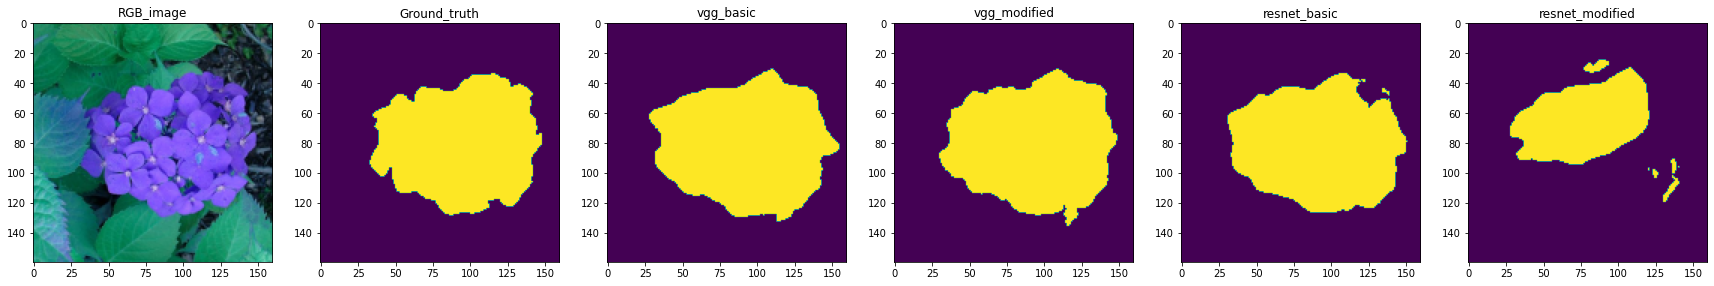

E_score_vgg_basic: 0.934547603053193
E_score_vgg_modified: 0.9001480828050964
E_score_Resnet_basic: 0.9467457188938526
E_score_Resnet_modified: 0.9378932417577112


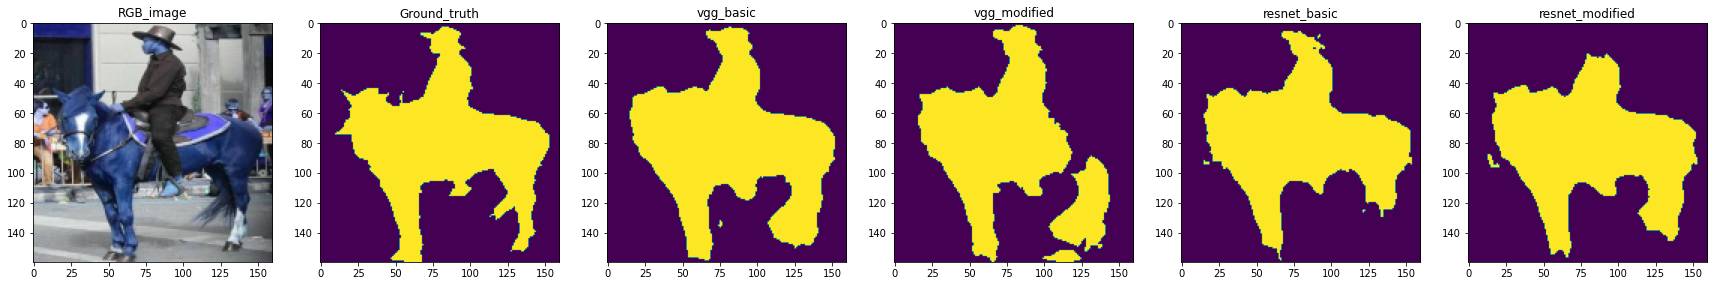

E_score_vgg_basic: 0.9596369296626525
E_score_vgg_modified: 0.9652267757554257
E_score_Resnet_basic: 0.9588995316453022
E_score_Resnet_modified: 0.8271212139966991


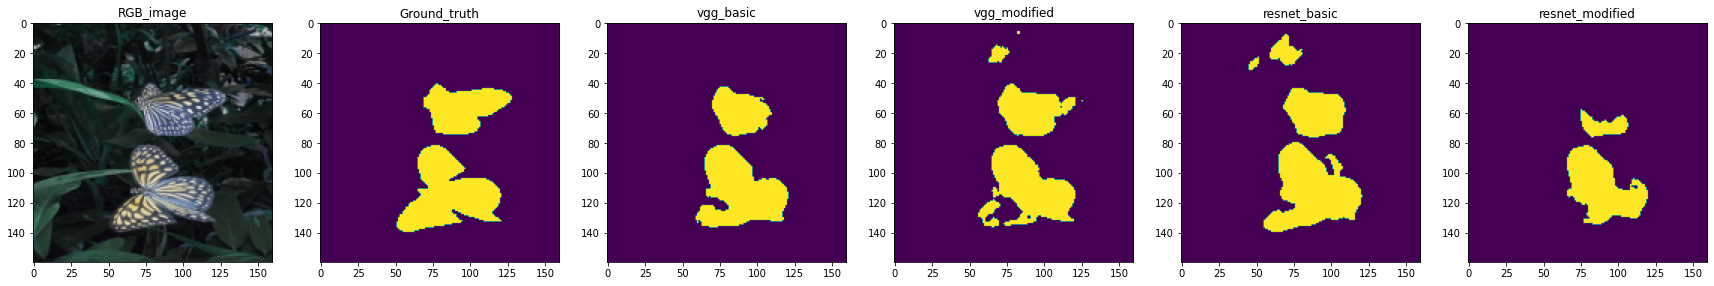

E_score_vgg_basic: 0.9669718630799292
E_score_vgg_modified: 0.92743088915977
E_score_Resnet_basic: 0.9733303977264837
E_score_Resnet_modified: 0.9795185909449832


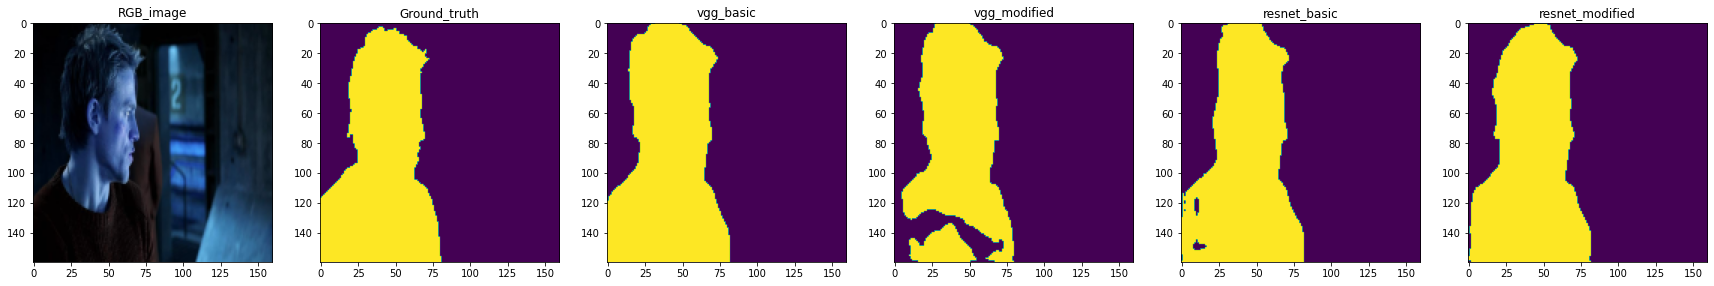

E_score_vgg_basic: 0.9450238881984248
E_score_vgg_modified: 0.9548915818496905
E_score_Resnet_basic: 0.8821669973659053
E_score_Resnet_modified: 0.9017324460569229


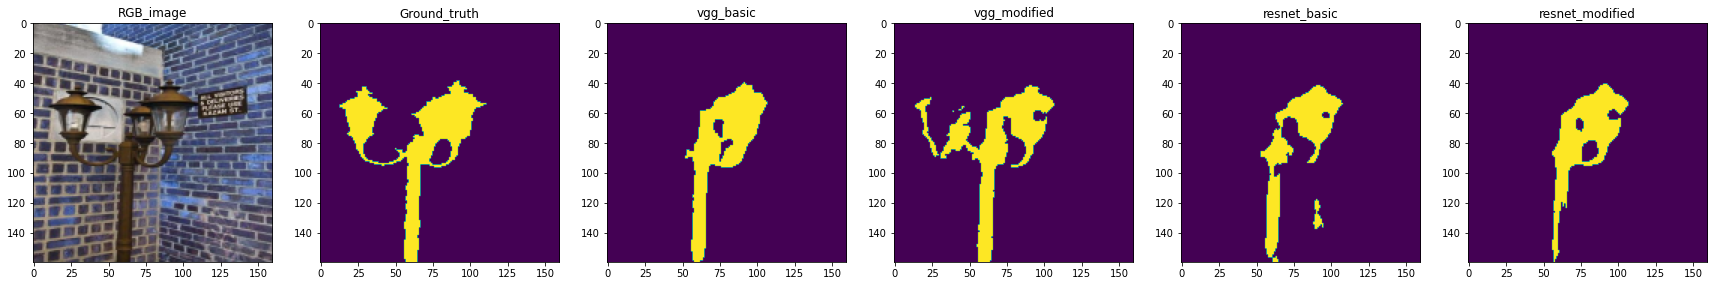

E_score_vgg_basic: 0.969506528216444
E_score_vgg_modified: 0.9773837576444769
E_score_Resnet_basic: 0.964775403592594
E_score_Resnet_modified: 0.9740124117816801


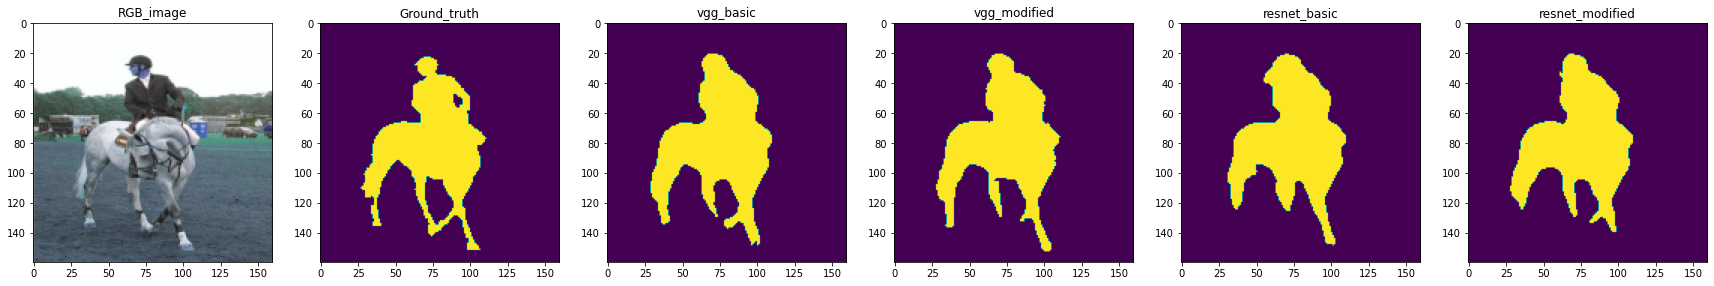

E_score_vgg_basic: 0.9408176866890666
E_score_vgg_modified: 0.95467718495977
E_score_Resnet_basic: 0.9426081380152387
E_score_Resnet_modified: 0.9470649475842269


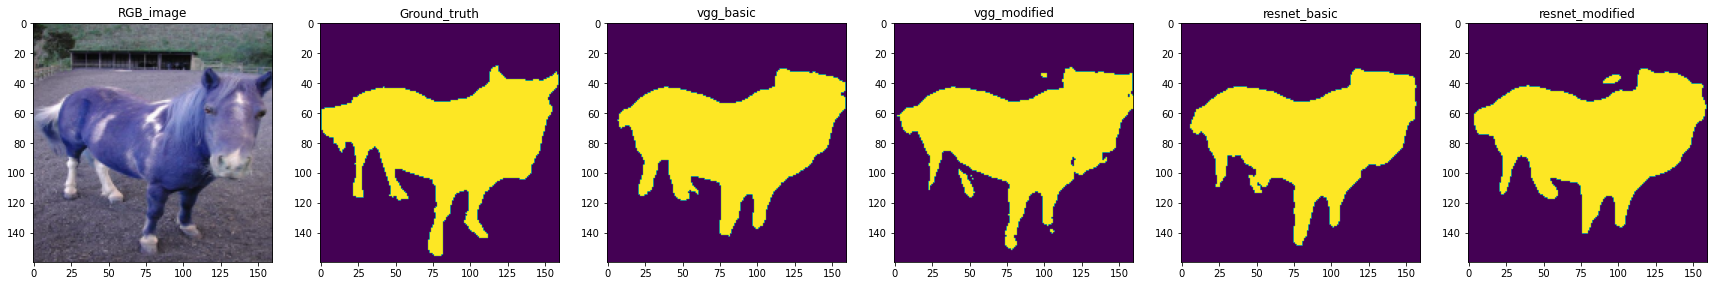

E_score_vgg_basic: 0.7126333547302995
E_score_vgg_modified: 0.9499348002250921
E_score_Resnet_basic: 0.5760239191936527
E_score_Resnet_modified: 0.4206614128860118


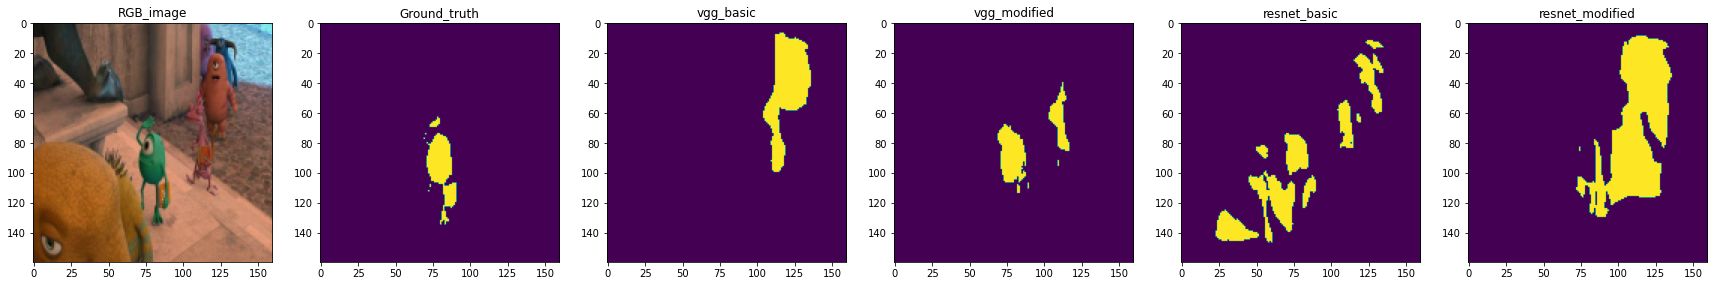

E_score_vgg_basic: 0.8315782221353101
E_score_vgg_modified: 0.8585659983064496
E_score_Resnet_basic: 0.8652717743613663
E_score_Resnet_modified: 0.9376861925820554


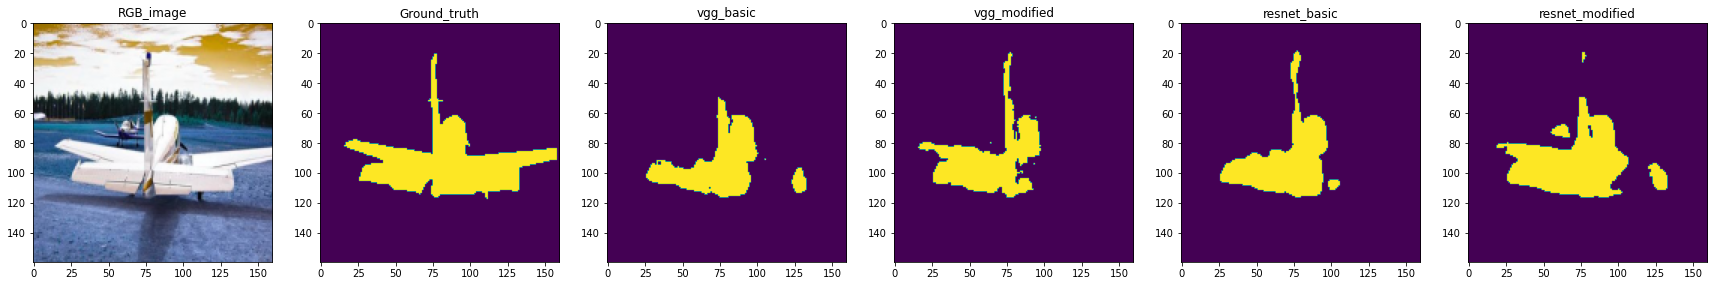

E_score_vgg_basic: 0.9300923281405042
E_score_vgg_modified: 0.9396321082568094
E_score_Resnet_basic: 0.8790550544720199
E_score_Resnet_modified: 0.913793691117874


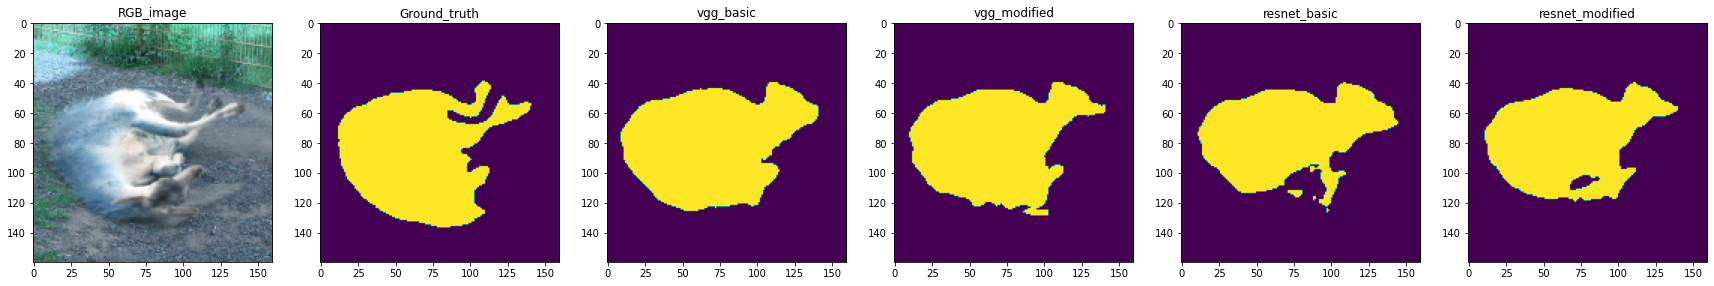

E_score_vgg_basic: 0.9876041317368572
E_score_vgg_modified: 0.9884359455607575
E_score_Resnet_basic: 0.9099643340303563
E_score_Resnet_modified: 0.9920976104012361


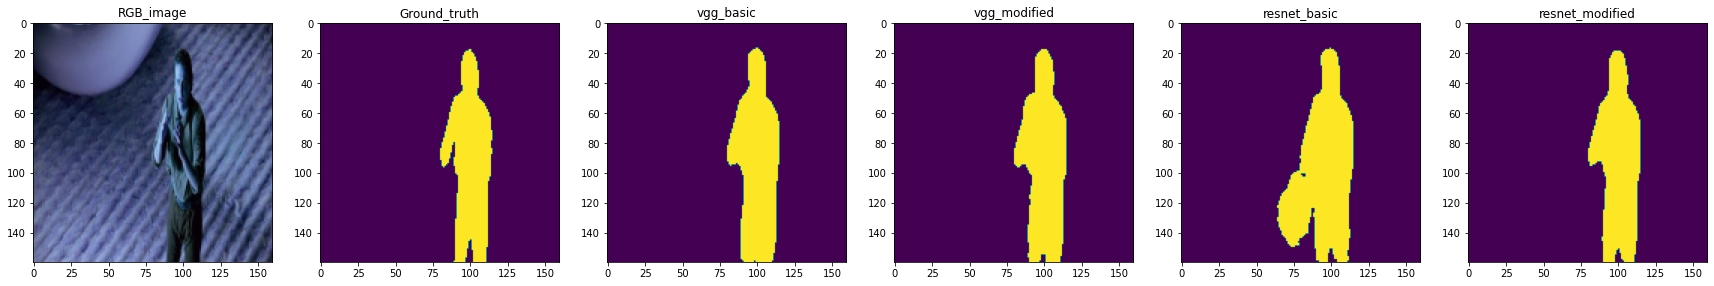

E_score_vgg_basic: 0.9901351738461435
E_score_vgg_modified: 0.9915147012083169
E_score_Resnet_basic: 0.9718803514745861
E_score_Resnet_modified: 0.9883686990345404


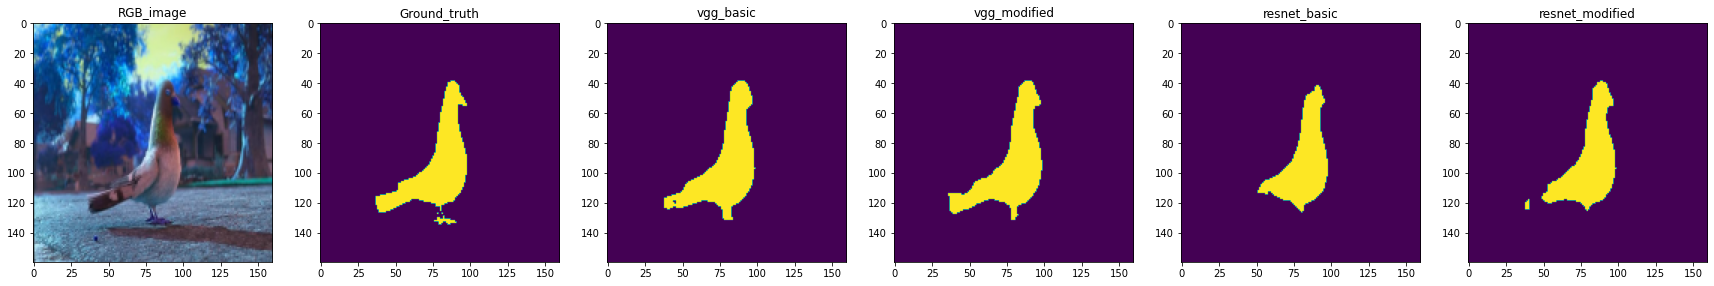

E_score_vgg_basic: 0.94102928180268
E_score_vgg_modified: 0.9568190329029203
E_score_Resnet_basic: 0.9375435973283635
E_score_Resnet_modified: 0.95149318099325


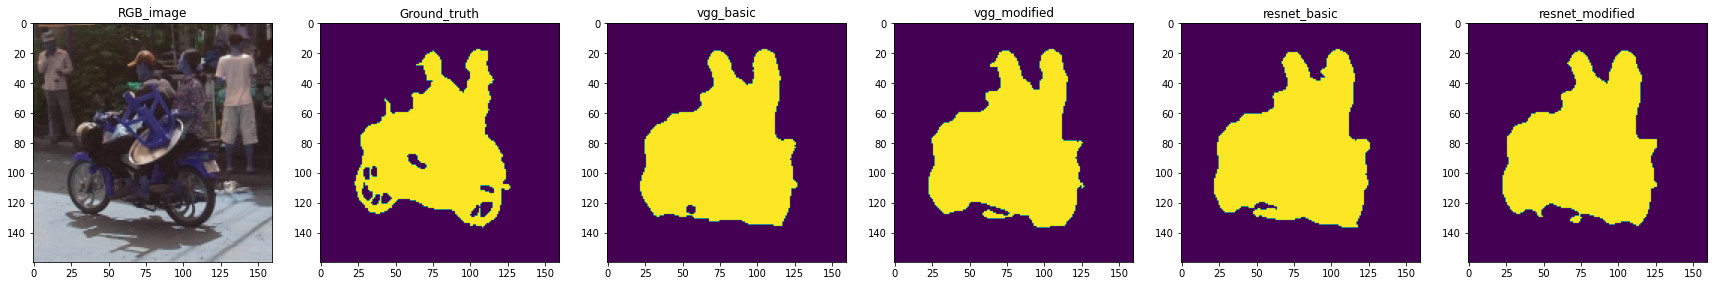

E_score_vgg_basic: 0.9300923281405042
E_score_vgg_modified: 0.9396321082568094
E_score_Resnet_basic: 0.8790550544720199
E_score_Resnet_modified: 0.913793691117874


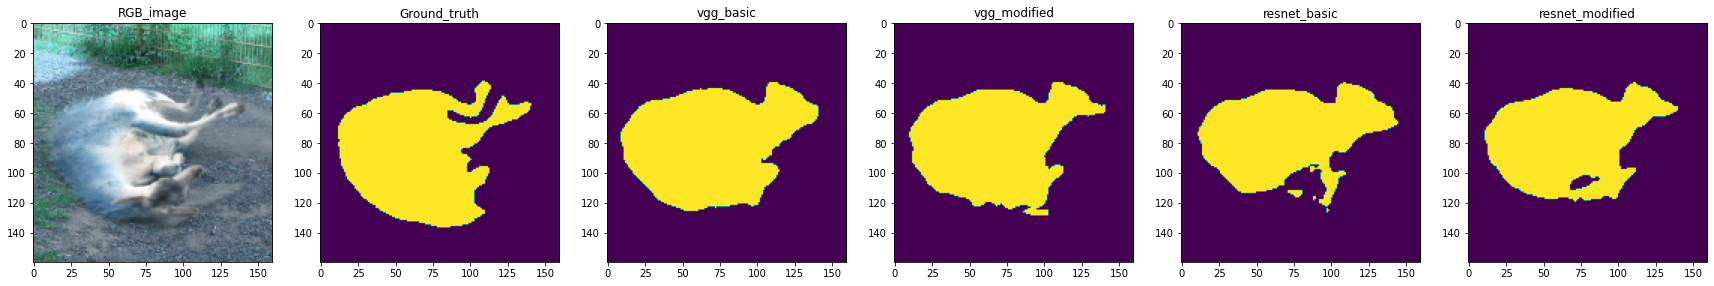

E_score_vgg_basic: 0.96553924985587
E_score_vgg_modified: 0.9701970243581656
E_score_Resnet_basic: 0.7628692575568313
E_score_Resnet_modified: 0.88649304505056


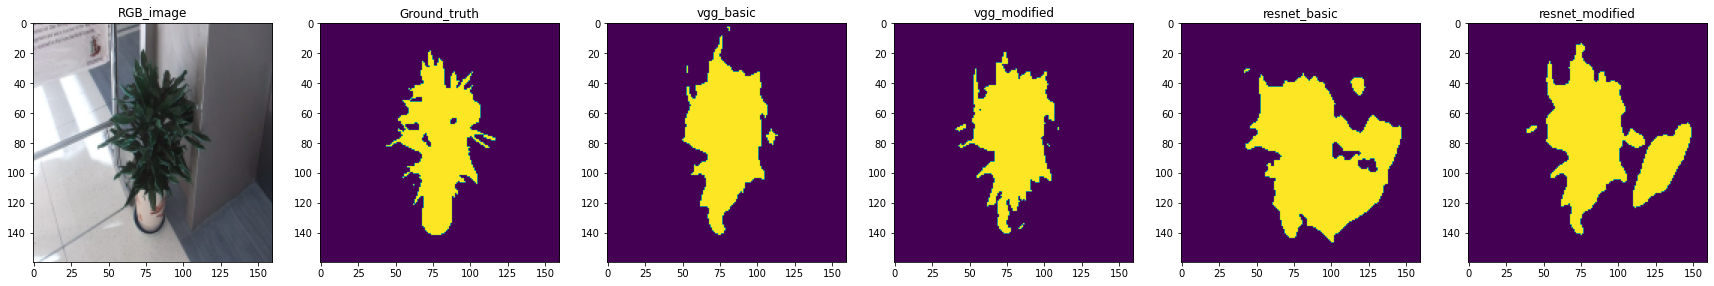

E_score_vgg_basic: 0.8441007469774009
E_score_vgg_modified: 0.9159640930826685
E_score_Resnet_basic: 0.6645435400119807
E_score_Resnet_modified: 0.6180815229225073


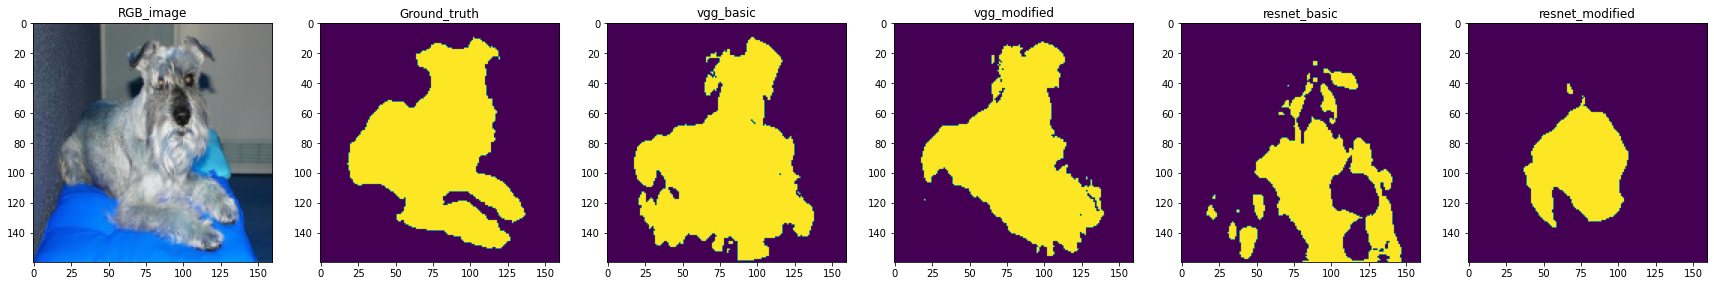

E_score_vgg_basic: 0.9485183038233933
E_score_vgg_modified: 0.9625036629256871
E_score_Resnet_basic: 0.9520681902534133
E_score_Resnet_modified: 0.9531380633489186


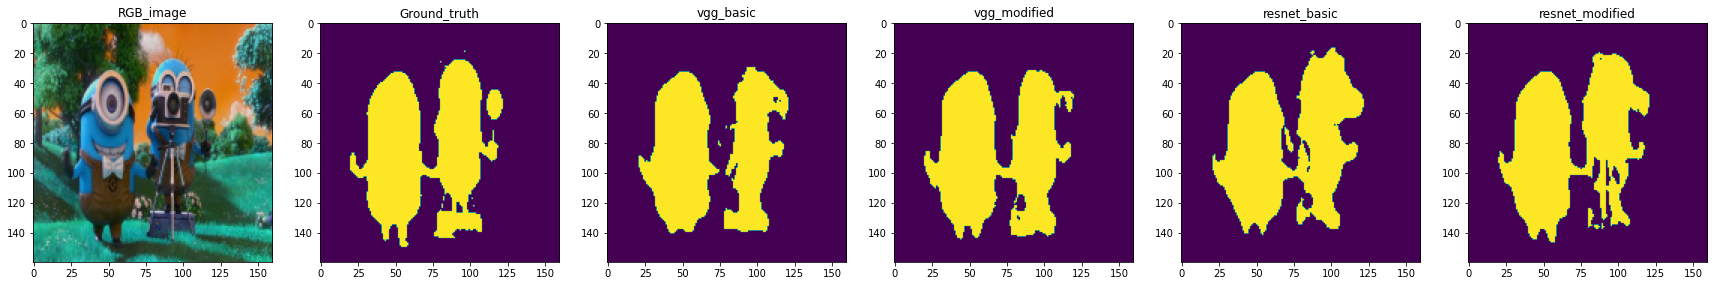

E_score_vgg_basic: 0.8967439120748066
E_score_vgg_modified: 0.8800896274793741
E_score_Resnet_basic: 0.9011177846204077
E_score_Resnet_modified: 0.9014308719440652


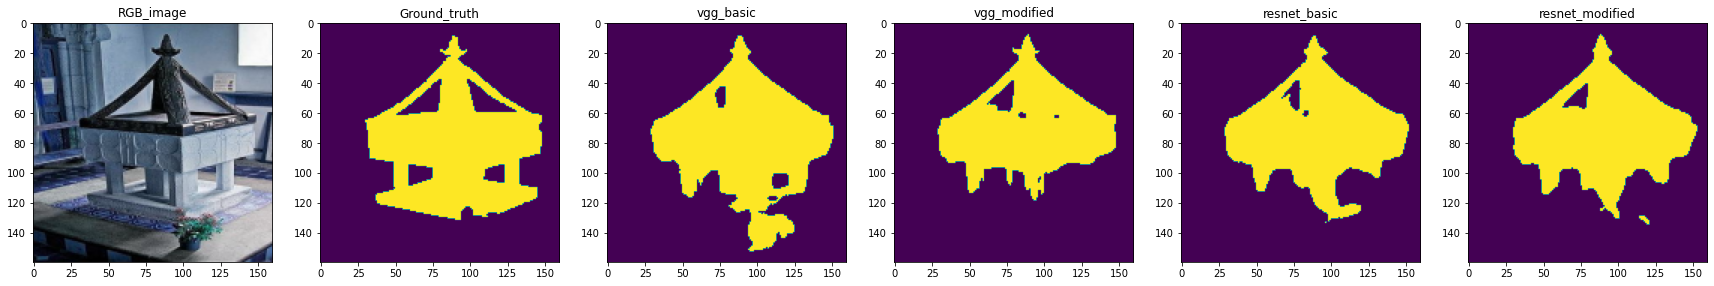

E_score_vgg_basic: 0.8925338602770543
E_score_vgg_modified: 0.9238679768288866
E_score_Resnet_basic: 0.9194587822074223
E_score_Resnet_modified: 0.9156721629268142


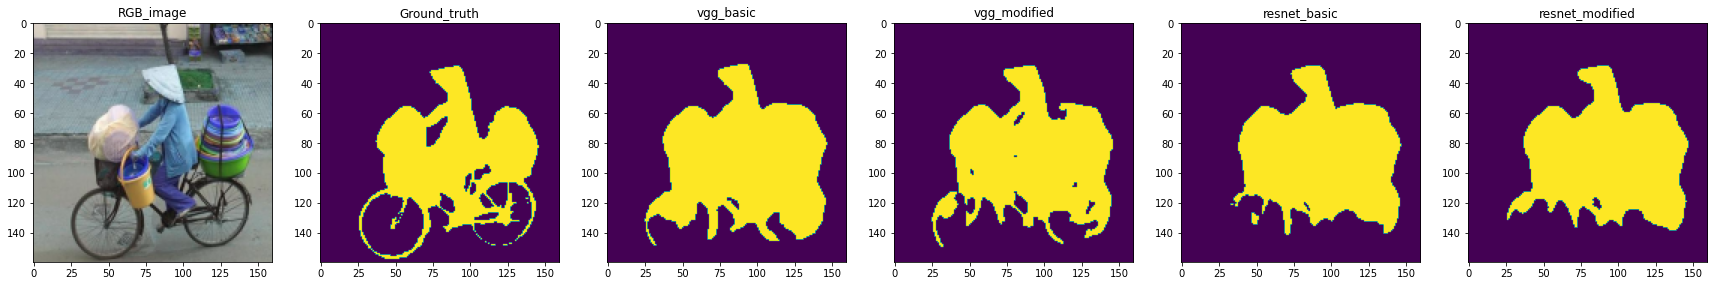

E_score_vgg_basic: 0.9383675561200283
E_score_vgg_modified: 0.9787400837671537
E_score_Resnet_basic: 0.9362433005008838
E_score_Resnet_modified: 0.8928436310490996


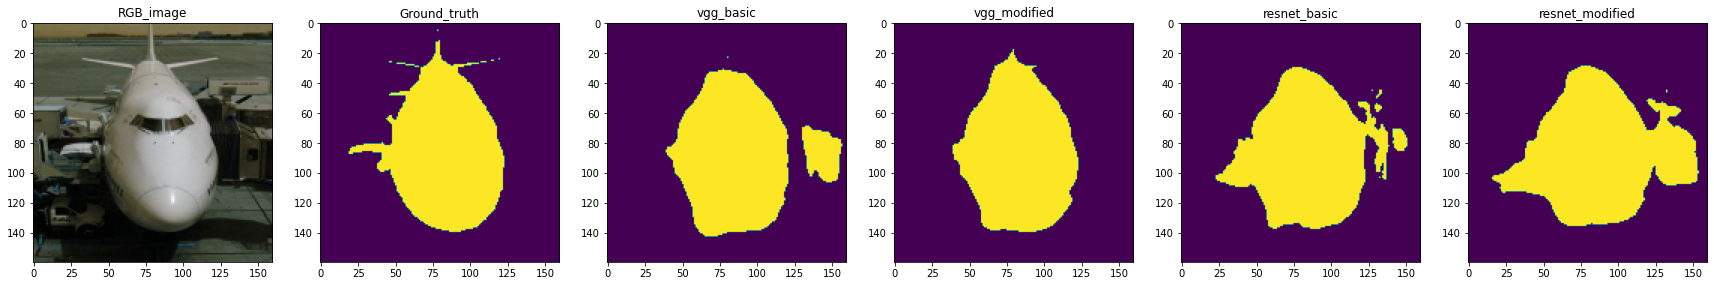

In [ ]:
### Randomly Printing the 20 predictions and based on their E-scores we can choose the best model

ranks=[]
for  i in range(20): 

    a=np.random.randint(0,397,1)
    images=X_test.values[a] 

    input=input_prep(images)
                                          
    #original image
    gt_image = np.argmax(np.reshape(input[1],(160,160,2)),axis=-1)*255

    #predicted saliency map                                                                                                                                                                                                        
    r,d,final1 = vgg_basic.predict(input[0])
    r,d,final2 = vgg_modified.predict(input[0])
    r,d,final3 = Resnet_basic.predict(input[0])
    r,d,final4 = Resnet_modified.predict(input[0])

    final1=np.argmax(final1,axis=-1)
    final2=np.argmax(final2,axis=-1)
    final3=np.argmax(final3,axis=-1)
    final4=np.argmax(final4,axis=-1)

    final1=final1*255
    final2=final2*255
    final3=final3*255
    final4=final4*255

    plt.figure(figsize=(30,10))
    plt.subplot(161)
    plt.title('RGB_image')
    plt.imshow(np.reshape(input[0][0],(160,160,3)))   

    plt.subplot(162)
    plt.title('Ground_truth')
    plt.imshow(gt_image)

    plt.subplot(163)
    plt.title('vgg_basic')
    plt.imshow(np.reshape(final1,(160,160)))

    plt.subplot(164)
    plt.title('vgg_modified')
    plt.imshow(np.reshape(final2,(160,160)))

    plt.subplot(165)
    plt.title('resnet_basic')
    plt.imshow(np.reshape(final3,(160,160)))

    plt.subplot(166)
    plt.title('resnet_modified')
    plt.imshow(np.reshape(final4,(160,160)))
    
    predictions=[final1,final2,final3,final4]
    scores=[]
    for i in range(4):
      score=E_score(np.reshape(gt_image,(1,160,160)),np.reshape(predictions[i],(1,160,160)))
      scores.append(score)
    ranks.append(np.argmax(np.array(scores)))
    print('E_score_vgg_basic:',scores[0]) 
    print('E_score_vgg_modified:',scores[1]) 
    print('E_score_Resnet_basic:',scores[2]) 
    print('E_score_Resnet_modified:',scores[3])                                                          
    plt.show()

In [ ]:
## 1st attempt
ranks

[1, 1, 0, 1, 0, 1, 1, 1, 3, 0, 3, 2, 1, 1, 1, 1, 0, 3, 3, 1]

out of 20 predictions 11 times vgg_modified given the better results

4 times vgg_basic and resnet_modified given the better predictions

Resnet_basic gave the better results only one time

In [ ]:
### 2nd attempt
ranks

[2, 1, 1, 0, 1, 3, 1, 0, 1, 1, 3, 3, 0, 1, 2, 1, 3, 1, 1, 3]

out of 20 predictions 10 times vgg_modified given the better results

5 times resnet_modified given the better predictions

3 times vgg_basic given the better predictions

Resnet_basic gave the better results only 2 times

In [ ]:
## 3rd attempt
ranks

[1, 2, 1, 3, 1, 1, 1, 1, 3, 1, 3, 1, 1, 1, 1, 1, 1, 3, 1, 1]

out of 20 predictions 15 times vgg_modified given the better results

4 times resnet_modified given the better predictions


Resnet_basic gave the better results only 1 time

We attempted three times and in all the three trails the vgg_modified model gave the better scores. We can pick the vgg_modified as our best model

Dividing the test data into best,medium,bad and worst sets: Divided the samples based on the following thresholds values

E_score>=0.95 as best

0.85<= E_score < 0.95 as medium

0.50<= E_score < 0.85 as Bad 

E_score < 0.50 as worst 


In [ ]:
best_test=[]
medium_test=[]
bad_test=[]
worst_test=[]
for  i in range(len(X_test.values)): 

 
    images=[X_test.values[i]]

    input=input_prep(images)
                                       
    #original image
    gt_image = np.argmax(np.reshape(input[1],(160,160,2)),axis=-1)*255

    #predicted saliency map                                                                                                                                                                                                        
    
    r,d,final = vgg_modified.predict(input[0])

    final=np.argmax(final,axis=-1)
   
    final=final*255

    score=E_score(np.reshape(gt_image,(1,160,160)),np.reshape(final,(1,160,160)))

    if score>=0.95:
      best_test.append(i)
    if score>=0.85 and score<0.95:
      medium_test.append(i)
    if score>=0.50 and score<0.85:
      bad_test.append(i)
    if score<0.5:
      worst_test.append(i)


In [ ]:
print(len(best_test))
print(len(medium_test))
print(len(bad_test))
print(len(worst_test))

219
97
67
14


Out of 397 test samples the model predicting 14 samples as worst which is 3.52% of total samples and 67 samples as bad (16.87% of total samples) let's see these 14 samples along with ground truth:

E_score: 0.41677774250140487


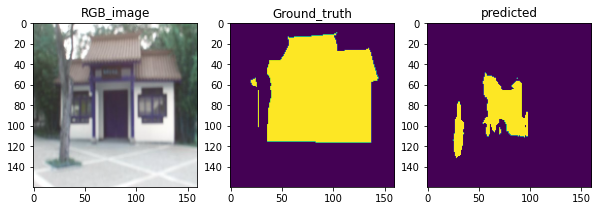

E_score: 0.48707197501250604


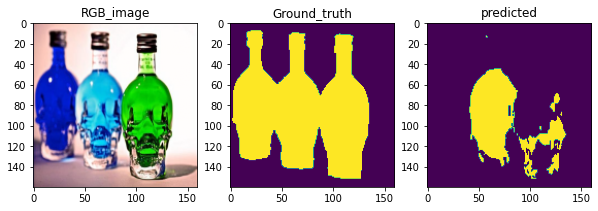

E_score: 0.39728624863185913


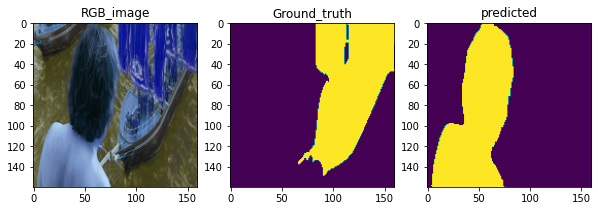

E_score: 0.4654025999637469


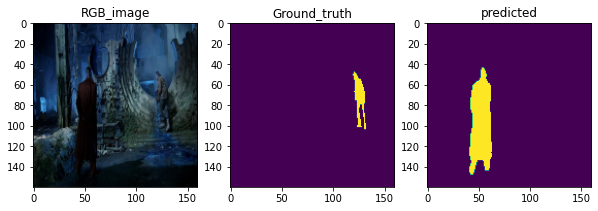

E_score: 0.47716484069010795


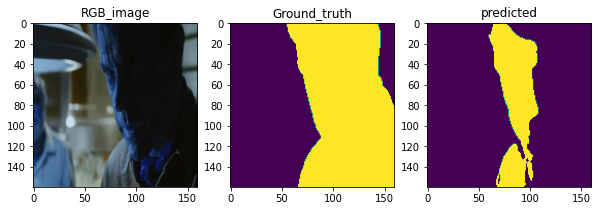

E_score: 0.3501346938327793


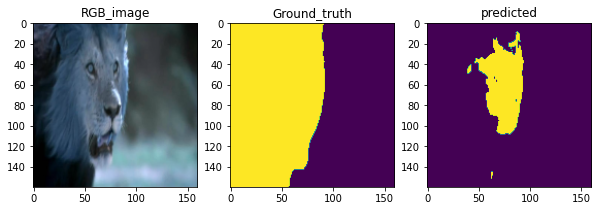

E_score: 0.4340986793533379


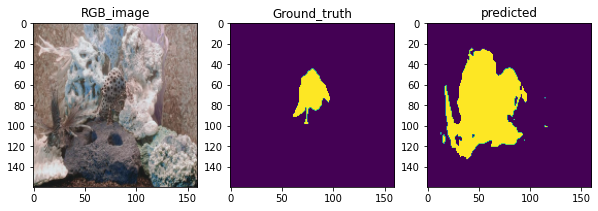

E_score: 0.29529605556077354


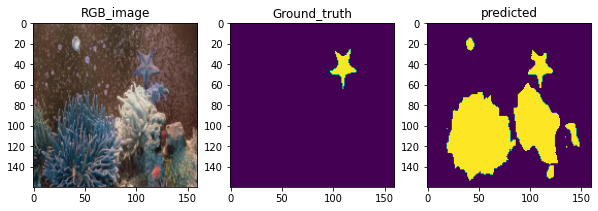

E_score: 0.2695209233362031


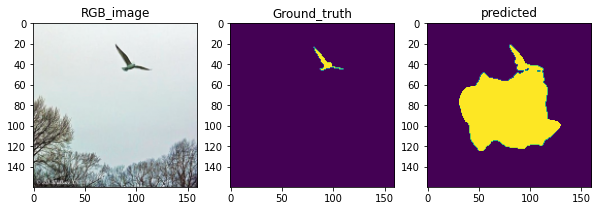

E_score: 0.49105734135596696


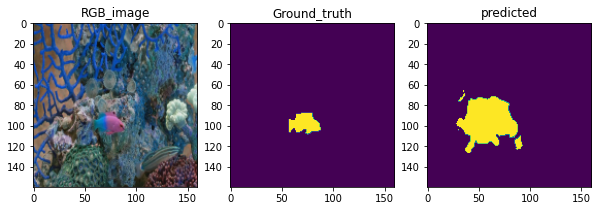

E_score: 0.49942043432757094


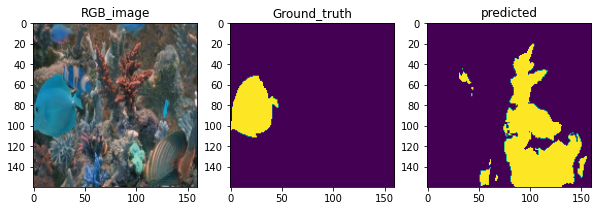

E_score: 0.492568585506978


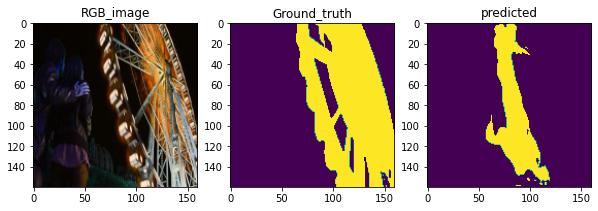

E_score: 0.32643027099047633


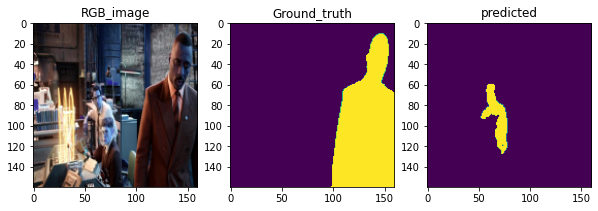

E_score: 0.4596942470686431


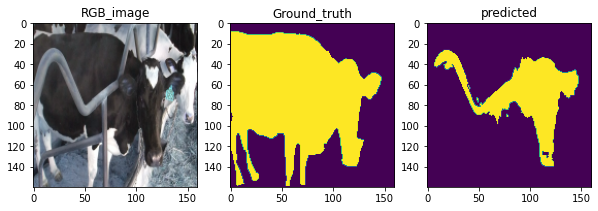

In [ ]:


for  i in range(len(worst_test)): 

    images=[X_test.values[worst_test[i]]] 

    input=input_prep(images)
                                          
    #original image
    gt_image = np.argmax(np.reshape(input[1],(160,160,2)),axis=-1)*255

    #predicted saliency map                                                                                                                                                                                                        
    r,d,final = vgg_modified.predict(input[0])

    final=np.argmax(final,axis=-1)
   
    final=final*255

    plt.figure(figsize=(10,10))
    plt.subplot(131)
    plt.title('RGB_image')
    plt.imshow(np.reshape(input[0][0],(160,160,3)))   

    plt.subplot(132)
    plt.title('Ground_truth')
    plt.imshow(gt_image)

    plt.subplot(133)
    plt.title('predicted')
    plt.imshow(np.reshape(final,(160,160)))

    
    score=E_score(np.reshape(gt_image,(1,160,160)),np.reshape(final,(1,160,160)))

    
    print('E_score:',score) 
                                                             
    plt.show()

All these worst predicted images are having multiple objects and somewhat blurred and low lighting images.Here, we can observe that for some images the model detecting the other objects instead of the object in the ground truth image. Because of this the E-score is very less and loss not converging well 

Dividing the train data:

In [ ]:
best_train=[]
medium_train=[]
bad_train=[]
worst_train=[]
for  i in range(len(X_train.values)): 

 
    images=[X_train.values[i]]

    input=input_prep(images)
                                       
    #original image
    gt_image = np.argmax(np.reshape(input[1],(160,160,2)),axis=-1)*255

    #predicted saliency map                                                                                                                                                                                                        
    
    r,d,final = vgg_modified.predict(input[0])

    final=np.argmax(final,axis=-1)
   
    final=final*255

    score=E_score(np.reshape(gt_image,(1,160,160)),np.reshape(final,(1,160,160)))

    if score>=0.95:
      best_train.append(i)
    if score>=0.85 and score<0.95:
      medium_train.append(i)
    if score>=0.50 and score<0.85:
      bad_train.append(i)
    if score<0.5:
      worst_train.append(i)


In [ ]:
print(len(best_train))
print(len(medium_train))
print(len(bad_train))
print(len(worst_train))

1331
230
24
3


In [ ]:
worst_train

[251, 888, 1570]

E_score: 0.28411416836376435


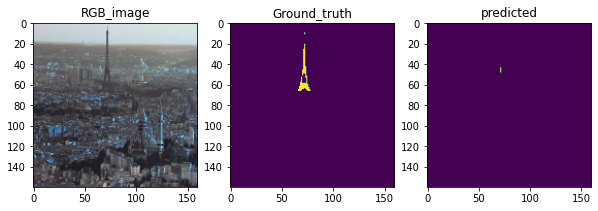

E_score: 0.41478439430264075


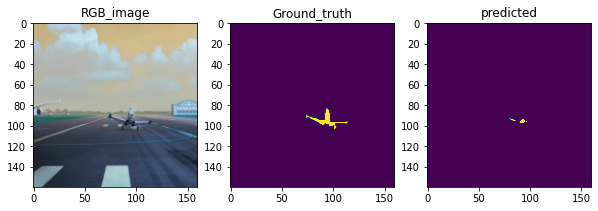

E_score: 0.43263354144079463


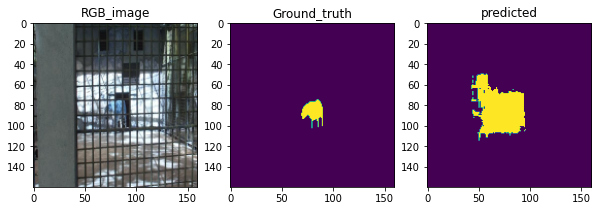

In [ ]:
import matplotlib.pyplot as plt

for  i in range(len(worst_train)): 

    images=[X_train.values[worst_train[i]]] 

    input=input_prep(images)
                                          
    #original image
    gt_image = np.argmax(np.reshape(input[1],(160,160,2)),axis=-1)*255

    #predicted saliency map                                                                                                                                                                                                        
    r,d,final = vgg_modified.predict(input[0])

    final=np.argmax(final,axis=-1)
   
    final=final*255

    plt.figure(figsize=(10,10))
    plt.subplot(131)
    plt.title('RGB_image')
    plt.imshow(np.reshape(input[0][0],(160,160,3)))   

    plt.subplot(132)
    plt.title('Ground_truth')
    plt.imshow(gt_image)

    plt.subplot(133)
    plt.title('predicted')
    plt.imshow(np.reshape(final,(160,160)))

    
    score=E_score(np.reshape(gt_image,(1,160,160)),np.reshape(final,(1,160,160)))

    
    print('E_score:',score) 
                                                             
    plt.show()

Here in the case of training data, the model predicts 3 images as worst.in all these three images the object is very deep and not clear.Due to this the model may not recognise the object 